# Data Overview

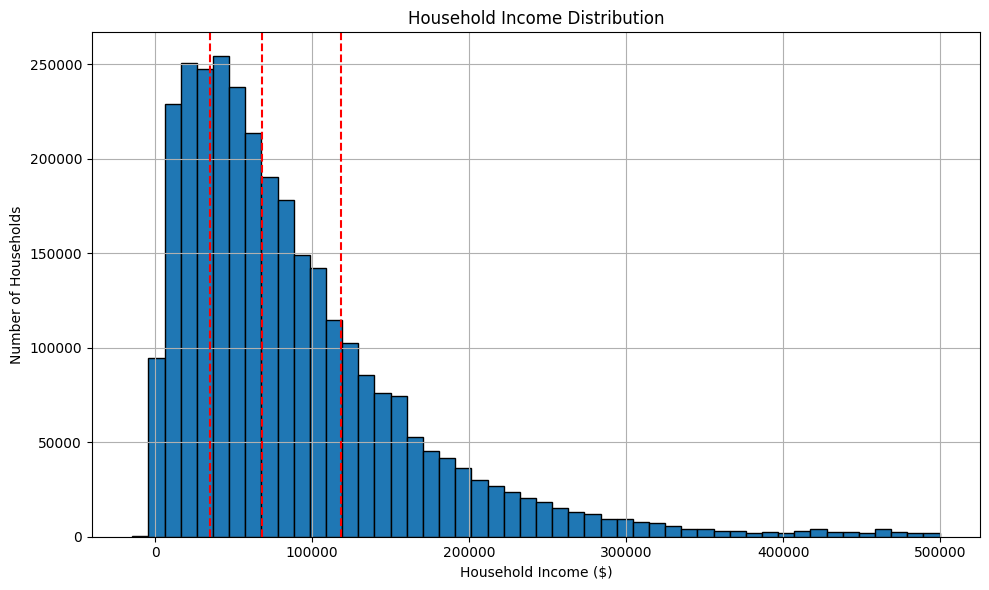

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load household file
household_df = pd.read_csv('va_household.csv')

# Drop missing or extreme values if needed
income = household_df['hh_income'].dropna()
income = income[income < 500000]  # optional upper cap to remove outliers

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(income, bins=50, edgecolor='black')
for q in [0.25, 0.5, 0.75]:
    plt.axvline(income.quantile(q), color='red', linestyle='--', label=f'{int(q*100)}th percentile')
plt.title("Household Income Distribution")
plt.xlabel("Household Income ($)")
plt.ylabel("Number of Households")
plt.grid(True)
plt.tight_layout()
plt.show()


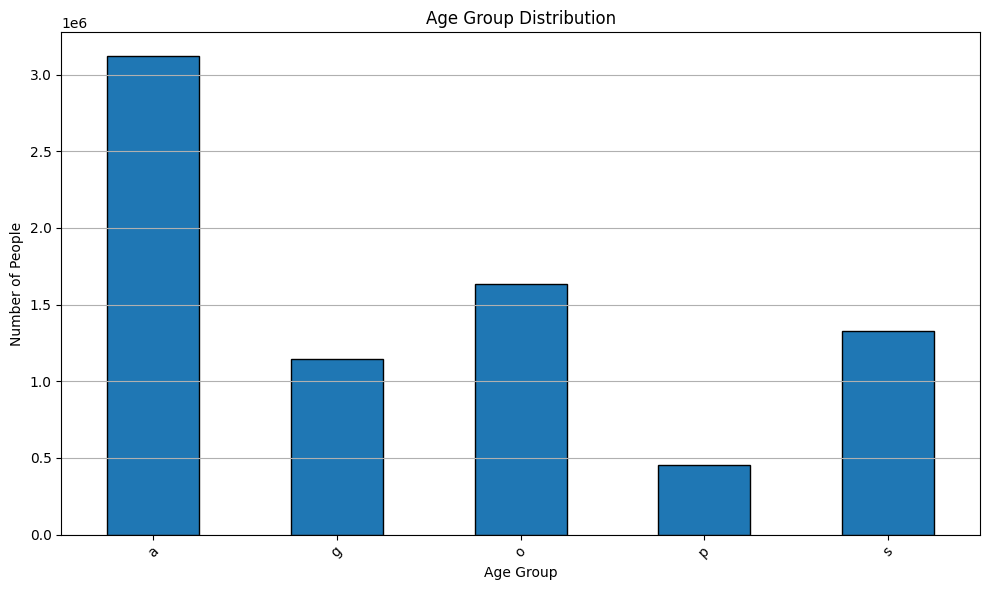

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
people_df = pd.read_csv('va_persontrait_epihiper.txt', sep=",", skiprows=1)

# Count by age group
age_counts = people_df['age_group'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
age_counts.plot(kind='bar', edgecolor='black')
plt.title("Age Group Distribution")
plt.xlabel("Age Group")
plt.ylabel("Number of People")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


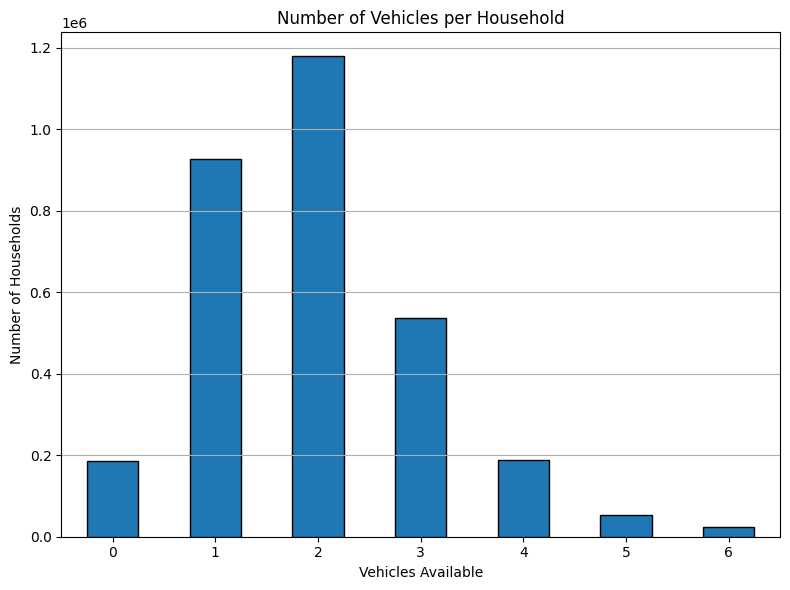

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
household_df = pd.read_csv("va_household.csv")

# Clean the vehicles column
vehicle_counts = household_df['vehicles'].dropna().astype(int)

# Count number of households by vehicle count
vehicle_distribution = vehicle_counts.value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 6))
vehicle_distribution.plot(kind='bar', edgecolor='black')
plt.title("Number of Vehicles per Household")
plt.xlabel("Vehicles Available")
plt.ylabel("Number of Households")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# LineList Construction

In [7]:
import pandas as pd
import numpy as np

# Load data
people_df = pd.read_csv('va_persontrait_epihiper.txt', sep=",", skiprows=1)  # contains pid, hid, ...
household_df = pd.read_csv('va_household.csv')  # contains hid, hh_income, etc.

# Load RUCC lookup
rucc_long = pd.read_csv("Ruralurbancontinuumcodes2023.csv",encoding="latin1")

# Pivot to wide format
rucc_wide = rucc_long.pivot_table(
    index=["FIPS", "State", "County_Name"],
    columns="Attribute",
    values="Value",
    aggfunc='first'
).reset_index()

# Rename for clarity
rucc_wide = rucc_wide.rename(columns={"RUCC_2023": "rucc_code"})
rucc_wide['rucc_code'] = pd.to_numeric(rucc_wide['rucc_code'], errors='coerce')

# Ensure both are string with 5-digit format
people_df['county_fips'] = people_df['county_fips'].astype(str).str.zfill(5)
rucc_wide['FIPS'] = rucc_wide['FIPS'].astype(str).str.zfill(5)

# Merge RUCC code into people
people_df = people_df.merge(
    rucc_wide[['FIPS', 'rucc_code']],
    left_on='county_fips',
    right_on='FIPS',
    how='left'
)

# Merge on household ID
df = people_df.merge(household_df, on='hid', how='left')

In [15]:
def compute_testing_probability(row):
    p = 0.5  # baseline

    # Income-based bias
    if pd.notnull(row['hh_income']):
        if row['hh_income'] < 40000:
            p *= 0.6
        elif row['hh_income'] < 70000:
            p *= 0.8
        elif row['hh_income'] < 110000:
            p *= 1.0
        else:
            p*=1.2

    # Age group
    if row['age_group'] == 'p':
        p *= 0.5
    elif row['age_group'] == 's':
        p *= 0.7
    elif row['age_group'] == 'a':
        p *= 1.0
    elif row['age_group'] == 'o':
        p *= 1.2
    elif row['age_group'] == 'g':
        p *= 1.4

    # Race group
    race = row['smh_race']
    if race == 'W':
        p *= 1.0
    elif race == 'A':
        p *= 0.85
    elif race == 'B':
        p *= 0.8
    elif race == 'L':
        p *= 0.75
    elif race == 'O':
        p *= 0.7

    # Occupation: higher testing for essential
    soc_code = str(row['occupation_socp'])
    # Handle missing/none
    if soc_code.lower() in ['none', 'n/a']:
        return p * 0.8

    # Extract SOC major group (first 2 digits)
    major_group = soc_code[:2]
    if major_group == '29':       # Healthcare
        p *= 1.4
    elif major_group == '35':     # Food service
        p *= 1.1
    elif major_group == '25':     # Education
        p *= 1.2
    elif major_group in ['11', '13']:  # Management, business
        p *= 1.0
    elif major_group in ['41', '53']:  # Sales, transport
        p *= 0.9
    elif major_group == '51':     # Manufacturing / production
        p *= 0.85
    else:
        p *= 0.7  # No job

    # Vehicles available (proxy for mobility/access)
    v = int(row['vehicles'])
    if v == 0:
        p *= 0.7
    elif v == 1:
        p *= 0.9
    else:  # 2 or more
        p *= 1.0

    # Live in rural/city
    rucc = row['rucc_code']
    if rucc <= 3:
        p *= 1.0  # metro
    elif rucc <= 6:
        p *= 0.85  # suburban/small city
    else:
        p *= 0.7  # rural

    return min(max(p, 0), 1)

In [16]:
# Compute testing probabilities
df['test_prob'] = df.apply(compute_testing_probability, axis=1)

# Simulate who came to test
df['tested_positive'] = np.random.binomial(1, df['test_prob'])

# Final linelist
linelist_df = df[df['tested_positive'] == 1].copy()

In [17]:
linelist_df.to_csv('simulated_test_positive_linelist.csv', index=False)

# Result Comparison

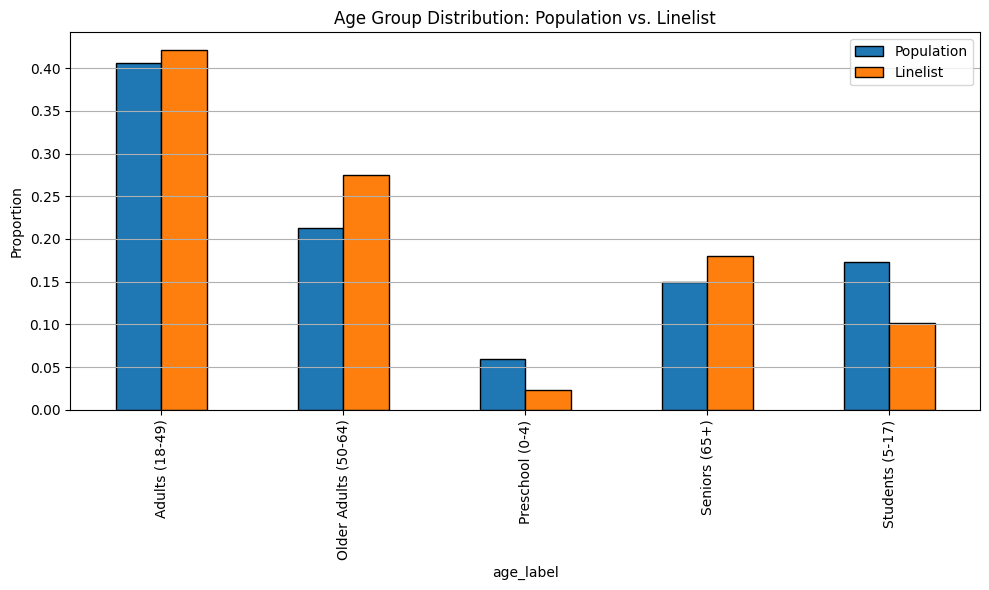

In [25]:
import matplotlib.pyplot as plt

# Map age group codes to labels
age_map = {
    "p": "Preschool (0-4)",
    "s": "Students (5-17)",
    "a": "Adults (18-49)",
    "o": "Older Adults (50-64)",
    "g": "Seniors (65+)"
}
df['age_label'] = df['age_group'].map(age_map)
linelist_df['age_label'] = linelist_df['age_group'].map(age_map)

# Count per age group in population vs. linelist
pop_age = df['age_label'].value_counts(normalize=True).sort_index()
line_age = linelist_df['age_label'].value_counts(normalize=True).sort_index()

# Combine into a DataFrame
age_comp = pd.DataFrame({'Population': pop_age, 'Linelist': line_age})

# Plot
age_comp.plot(kind='bar', figsize=(10, 6), edgecolor='black')
plt.title("Age Group Distribution: Population vs. Linelist")
plt.ylabel("Proportion")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


<Axes: title={'center': 'Race Distribution'}, xlabel='smh_race_label'>

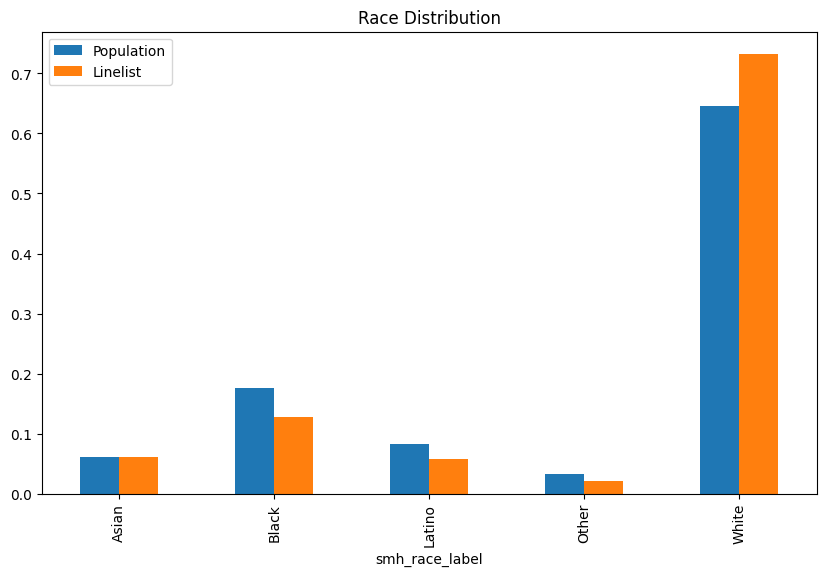

In [26]:
df["smh_race_label"] = df["smh_race"].astype(str).map({
    "W": "White", "B": "Black",
    "L": "Latino", "A": "Asian",
    "O": "Other"
})

linelist_df["smh_race_label"] = linelist_df["smh_race"].astype(str).map({
    "W": "White", "B": "Black",
    "L": "Latino", "A": "Asian",
    "O": "Other"
})

race_comp = pd.DataFrame({
    'Population': df['smh_race_label'].value_counts(normalize=True),
    'Linelist': linelist_df['smh_race_label'].value_counts(normalize=True)
})
race_comp.plot(kind='bar', title="Race Distribution", figsize=(10, 6))


<Axes: title={'center': 'Income Distribution'}, xlabel='income_bin'>

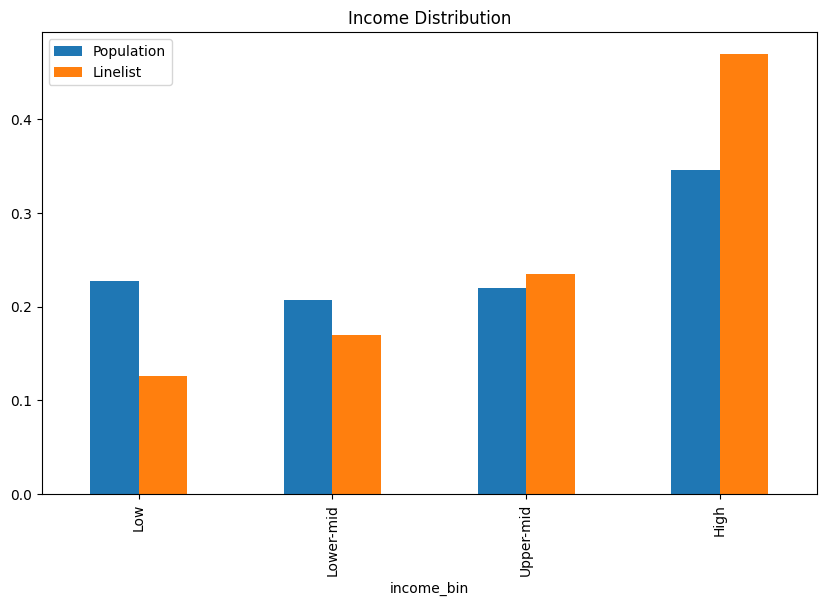

In [22]:
# Bin income into groups
bins = [0, 40000, 70000, 110000, float('inf')]
labels = ['Low', 'Lower-mid', 'Upper-mid', 'High']

df['income_bin'] = pd.cut(df['hh_income'], bins=bins, labels=labels)
linelist_df['income_bin'] = pd.cut(linelist_df['hh_income'], bins=bins, labels=labels)

income_comp = pd.DataFrame({
    'Population': df['income_bin'].value_counts(normalize=True),
    'Linelist': linelist_df['income_bin'].value_counts(normalize=True)
})
income_comp.plot(kind='bar', title="Income Distribution", figsize=(10, 6))


<Axes: title={'center': 'RUCC Code Distribution'}, xlabel='rucc_code'>

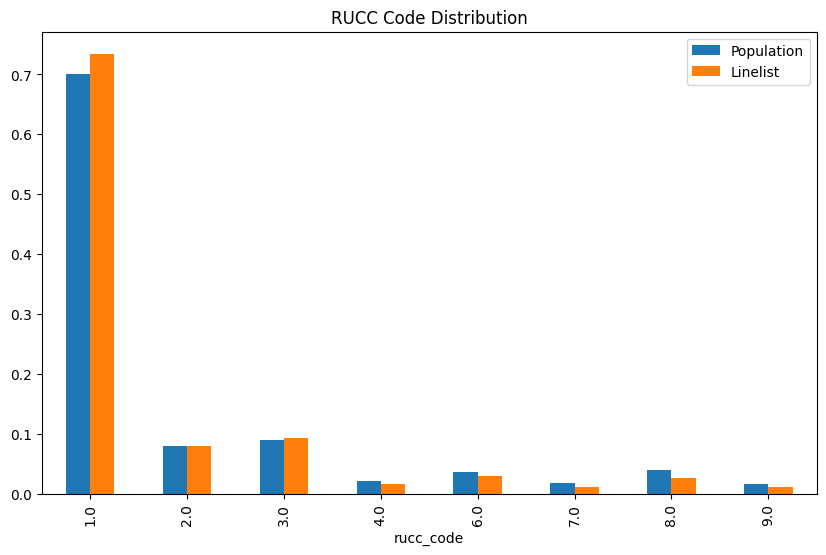

In [23]:
rucc_comp = pd.DataFrame({
    'Population': df['rucc_code'].value_counts(normalize=True).sort_index(),
    'Linelist': linelist_df['rucc_code'].value_counts(normalize=True).sort_index()
})
rucc_comp.plot(kind='bar', title="RUCC Code Distribution", figsize=(10, 6))
